In [1]:
!git clone https://github.com/mastryukov1990/mok_mas_gan2.git
!ls /content/mok_mas_gan2/*.py

Cloning into 'mok_mas_gan2'...
remote: Enumerating objects: 1219, done.
remote: Counting objects: 100% (1219/1219), done.
remote: Compressing objects: 100% (1102/1102), done.
remote: Total 1219 (delta 115), reused 1209 (delta 105), pack-reused 0
Receiving objects: 100% (1219/1219), 3.84 MiB | 889.00 KiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/mok_mas_gan2/main.py


In [2]:
from PIL import Image
from mok_mas_gan2.RaGAN.conf import IMSIZE
from torchvision import transforms
from mok_mas_gan2.RaGAN.utils import imshow
img = Image.open('/content/mok_mas_gan2/RaGAN/256_256.jpg')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IMSIZE,IMSIZE)),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])
img = transform(img)

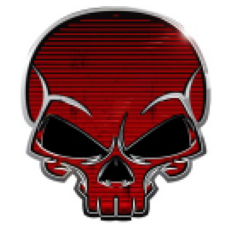

In [3]:
imshow(img)

In [4]:
import torch
wimg = torch.stack([img.view(3,IMSIZE,IMSIZE) ,img.view(3,IMSIZE,IMSIZE)])#example pic


In [5]:
from mok_mas_gan2.RaGAN.Conv2dBlock import Conv2dBlock
from mok_mas_gan2.RaGAN.JsonDataLoader import JsonDataLoader


gen = JsonDataLoader('/content/mok_mas_gan2/RaGAN/generator.json')
gen_params = gen.get_data()

dis = JsonDataLoader('/content/mok_mas_gan2/RaGAN/discriminator.json')
dis_params = dis.get_data()

In [6]:

from mok_mas_gan2.RaGAN.Generator import Generator
from mok_mas_gan2.RaGAN.Discriminator import Discriminator


disc = Discriminator(dis_params)
gen = Generator(gen_params)

In [7]:
from mok_mas_gan2.RaGAN.FinalLoss import FinalLoss

l = FinalLoss()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


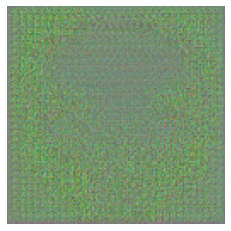

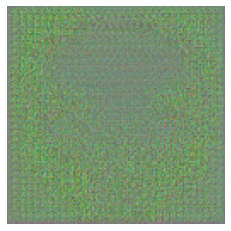

In [8]:
for i in gen(wimg):
  imshow(i.detach())
  

In [12]:
disc.train()

Discriminator(
  (global_branch): Sequential(
    (0): Conv2dBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (norm_act): NormActBlock(
          (block): Sequential(
            (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
          )
        )
      )
    )
    (1): Conv2dBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm_act): NormActBlock(
          (block): Sequential(
            (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): LeakyReLU(negative_slope=0.01)
          )
        )
      )
    )
    (2): Conv2dBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm_act): NormActBlock(
          (block): Sequ